<style>
.autofit .code_cell .input_area pre {
    font-size: 1vw;  /* Adjust this value as needed */
    line-height: 1.2;
}
</style>

# Scheduling in scikit-decide

## Icaps Tutorial 2024
Florent Teichteil Koenigsbuch, Alexandre Arnold, Guillaume Povéda

Credits to IMACS and Olivier Regnier-Coudert
In this tutorial notebook, you will be introduced to scheduling domains in scikit-decide.

In [1]:
# Basic installation of libraries and download of needed files (notably when using colab)
!wget https://raw.githubusercontent.com/fteicht/icaps24-skdecide-tutorial/main/notebooks/install_skdecide.py
!wget https://raw.githubusercontent.com/fteicht/icaps24-skdecide-tutorial/gpd/rcpsp_rl/notebooks/imports_notebook.py
!wget https://raw.githubusercontent.com/fteicht/icaps24-skdecide-tutorial/gpd/rcpsp_rl/notebooks/setup_environment_scheduling.py
import os
import logging
from install_skdecide import install_skdecide
install_skdecide(using_nightly_version=False, force_reinstall=False)
from imports_notebook import *
from setup_environment_scheduling import (download_files_needed,
                                          install_additional_dependencies)
#download_files_needed()
install_additional_dependencies(force_reinstall=False)
logging.basicConfig(level=logging.CRITICAL)

--2024-05-28 11:43:26--  https://raw.githubusercontent.com/fteicht/icaps24-skdecide-tutorial/main/notebooks/install_skdecide.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2539 (2,5K) [text/plain]
Saving to: ‘install_skdecide.py.3’

install_skdecide.py 100%[===================>]   2,48K  --.-KB/s    in 0s      

2024-05-28 11:43:26 (59,1 MB/s) - ‘install_skdecide.py.3’ saved [2539/2539]

--2024-05-28 11:43:26--  https://raw.githubusercontent.com/fteicht/icaps24-skdecide-tutorial/gpd/rcpsp_rl/notebooks/imports_notebook.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request

--2024-05-28 11:43:32--  https://raw.githubusercontent.com/fteicht/icaps24-skdecide-tutorial/gpd/rcpsp_rl/notebooks/rcpsp_domains/rcpsp_sk_domain.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12787 (12K) [text/plain]
Saving to: ‘/Users/poveda_g/Documents/git_repos/pub_repo/icaps24-skdecide-tutorial/notebooks/rcpsp_domains/rcpsp_sk_domain.py’

     0K .......... ..                                         100%  434K=0,03s

2024-05-28 11:43:32 (434 KB/s) - ‘/Users/poveda_g/Documents/git_repos/pub_repo/icaps24-skdecide-tutorial/notebooks/rcpsp_domains/rcpsp_sk_domain.py’ saved [12787/12787]

--2024-05-28 11:43:32--  https://raw.githubusercontent.com/fteicht/icaps24-skdecide-tutorial/gpd/rcpsp_rl/notebooks/rcpsp_domains/rcpsp_sk_domain_local_search.py
Resolv

Optuna is already installed and we are asked not to forcibly reinstall it
Optuna-Dashboard is already installed and we are asked not to forcibly reinstall it
Dash is already installed and we are asked not to forcibly reinstall it


### What is scheduling and how it is different from planning or control domains ?


Main characteristic of scheduling problems compared to classical planning : 
- Parallel tasks
- Time dimension is preponderant
- Complex time dependant constraint ?
- For most scheduling problems we know the task to accomplish in advance contrary to planning problems.

Solving technologies to solve scheduling problems :
- State of the art are more on operational research community : mathematical programming, metaheuristic, discrete optimization in general -> need to extend scikit-decide with such solver technologies ! 

## Scheduling API in scikit-decide
We developped a side API to be able to describe scheduling problems in scikit-decide.

<img src="images/skdecide_characteristics_1.png" alt="Example Image" width="40%">

Our base scheduling domain is : 

- SingleAgent : implementation choice, in practice some scheduling problem could be encoded as MA
- Sequential : even though task are executed in parallel we implement domain in a way that is compatible with Sequential caracteristic.
- Simulation : step function are stateless and can be somulated (sample transition from any state)
- DeterministicInitialized : we start from an empty schedule [could be changed]
- Actions : only controlled event like starting tasks are considered
- FullyObservable : we know the current status of the schedule
- Markovian : next state only depends on action and current state
- Goals : goal is to accomplish all task

### Additional features of scheduling problems : 
- WithPrecedence/WithoutPrecedence
- MultiMode/SingleMode
- VariableResourceConsumption/ConstantResourceConsumption
- WithPreemptivity/WithoutPreemptivity
- WithResourceTypes/WithoutResourceTypes
- WithResourceUnits/WithoutResourceUnits
- MixedRenewable/RenewableOnly
- SimulatedTaskDuration/UncertainMultivariateTaskDuration/UncertainUnivariateTaskDuration/UncertainBoundedTaskDuration/UniformBoundedTaskDuration/EnumerableTaskDuration/DeterministicTaskDuration
- CustomTaskProgress/DeterministicTaskProgress
- WithResourceSkills/WithoutResourceSkills
- WithTimeLag/WithoutTimeLag
- WithTimeWindow/WithoutTimeWindow
- WithPreallocations/WithoutPreallocations
- WihConditionalTasks/WithoutConditionnalTasks
- UncertainResourceAvilabilityChanges/DeterministicResourceAvailabilityChanges/WithoutResourceAvailabilityChange
- WithModeCosts/WithoutModeCosts
- WithResourceCosts/WithoutResourceCosts


### Domain implementation
#<Cite GPHH paper>
    
- State :
    - set of task done
    - set of remaining task
    - set of starting time for each task, current progress, and resource allocated to it
    - resource available
- Actions : 
    - Start a task and allocate some resource to it
    - Stop a task
    - Resume a task and allocate some resource to it
    - Do nothing (this will have no effect but to advance the simulation time to next time step or next event)

## RCPSP
Scikit-decide contains implementation of RCPSP and many other variants.
Resource-constrained

The problem is made of $M$ activities that have precedence constraints. That means that if activity $j \in [1,M]$ is a successor of activity $i \in [1,M]$, then activity $i$ must be completed before activity $j$ can be started/

On top of these constraints, each project is assigned a set of K renewable resources where each resource $k$ is available in $R_{k}$ units for the entire duration of the project. Each activity may require one or more of these resources to be completed. -- While scheduling the activities, the daily resource usage for resource $k$ can not exceed $R_{k}$ units.
- Each activity $j$ takes $d_{j}$ time units to complete
- The overall goal of the problem is usually to minimize the makespan

A classic variant of RCPSP is the multimode RCPSP where each task can be executed in several ways (one way=one mode). A typical example is :
- Mode n°1 'Fast mode': high resource consumption and fast
- Mode n°2 'Slow mode' : low resource consumption but slow

In [2]:
# Let's look what defines the classical RCPSP for example
SingleModeRCPSP??

Init signature: SingleModeRCPSP()
Source:        
class SingleModeRCPSP(
    DeterministicSchedulingDomain,
    SingleMode,
    DeterministicTaskDuration,
    DeterministicTaskProgress,
    WithoutResourceUnit,
    WithoutPreallocations,
    WithoutTimeLag,
    WithoutTimeWindow,
    WithoutResourceSkills,
    WithoutResourceAvailabilityChange,
    WithoutConditionalTasks,
    RenewableOnly,
    ConstantResourceConsumption,  # problem with unimplemented classes with this
    WithoutPreemptivity,  # problem with unimplemented classes with this
    WithoutModeCosts,
    WithoutResourceCosts,
):
    """
    Single mode (classic) Resource project scheduling problem template.
    It consists in :
    - a deterministic scheduling problem with precedence constraint between task
    - a set of renewable resource with constant availability (capacity)
    - task having deterministic resource consumption
    The goal is to minimize the overall makespan, respecting the cumulative resource consumpt

### Small RCPSP Domain

In [3]:
class VerySimple_RCPSPDomain(SingleModeRCPSP):
    def __init__(self):
        self.initialize_domain()

    def _get_objectives(self) -> List[SchedulingObjectiveEnum]:
        return [SchedulingObjectiveEnum.MAKESPAN]

    def _get_max_horizon(self) -> int:
        return 10

    def _get_successors(self) -> Dict[int, List[int]]:
        return {
            1: [2, 4],
            2: [3],
            3: [5],
            4: [5],
            5: [],
        }

    def _get_tasks_ids(self) -> Union[Set[int], Dict[int, Any], List[int]]:
        return set([*range(1, 6)])

    def _get_tasks_mode(self) -> Dict[int, ModeConsumption]:
        return {
            1: ConstantModeConsumption({"r1": 0}),
            2: ConstantModeConsumption({"r1": 4}),
            3: ConstantModeConsumption({"r1": 1}),
            4: ConstantModeConsumption({"r1": 0}),
            5: ConstantModeConsumption({"r1": 0}),
        }

    def _get_resource_types_names(self) -> List[str]:
        return ["r1"]

    def _get_task_duration(
        self, task: int, mode: Optional[int] = 1, progress_from: Optional[float] = 0.0
    ) -> int:
        all_durations = {1: 0, 2: 3, 3: 3, 4: 7, 5: 0}
        return all_durations[task]

    def _get_original_quantity_resource(self, resource: str, **kwargs) -> int:
        all_resource_quantities = {"r1": 7}
        return all_resource_quantities[resource]

In [4]:
domain = VerySimple_RCPSPDomain()
domain.set_inplace_environment(False)
state = domain.get_initial_state()
print(f" The state contains the following field:")
from pprint import pprint

pprint([x for x in dir(state) if not x.startswith("_")])

 The state contains the following field:
['copy',
 'resource_availability',
 'resource_to_task',
 'resource_used',
 'resource_used_for_task',
 't',
 'task_ids',
 'tasks_complete',
 'tasks_complete_details',
 'tasks_complete_mode',
 'tasks_complete_progress',
 'tasks_details',
 'tasks_full_details',
 'tasks_mode',
 'tasks_ongoing',
 'tasks_paused',
 'tasks_progress',
 'tasks_remaining',
 'tasks_unsatisfiable']


In [5]:
print(
    "\n\n".join([str(a) for a in domain.get_applicable_actions(state).get_elements()])
)

Action 
Task : 1
Mode : 1
Action type START
Time progress False
Resource : None

Action 
Task : None
Mode : None
Action type TIME_PR
Time progress True
Resource : None


#### Solving RCPSP domains

We will study 3 different ways of solving scheduling problem
- Classical graph search algorithm (A*) on (very small) instances
- Combinatorial optimization and heuristics
- Reinforcement learning

#### Solving with A*

Scheduling domain can be solved with compatible solver in the library scikit-decide. In the case of RCPSP, deterministic planning solver such as A* can be tried. This solver will onl work with tiny scheduling problem.

In [6]:
from skdecide.hub.solver.lazy_astar import LazyAstar

solver = LazyAstar(domain_factory=lambda: domain, heuristic=None)
solver.solve(from_memory=state)
episode = rollout(
    domain=domain, solver=solver, verbose=False, return_episodes=True, num_episodes=1
)[0]

2024-05-28 11:45:49,183 | skdecide.utils | INFO | The goal was reached in episode 1.


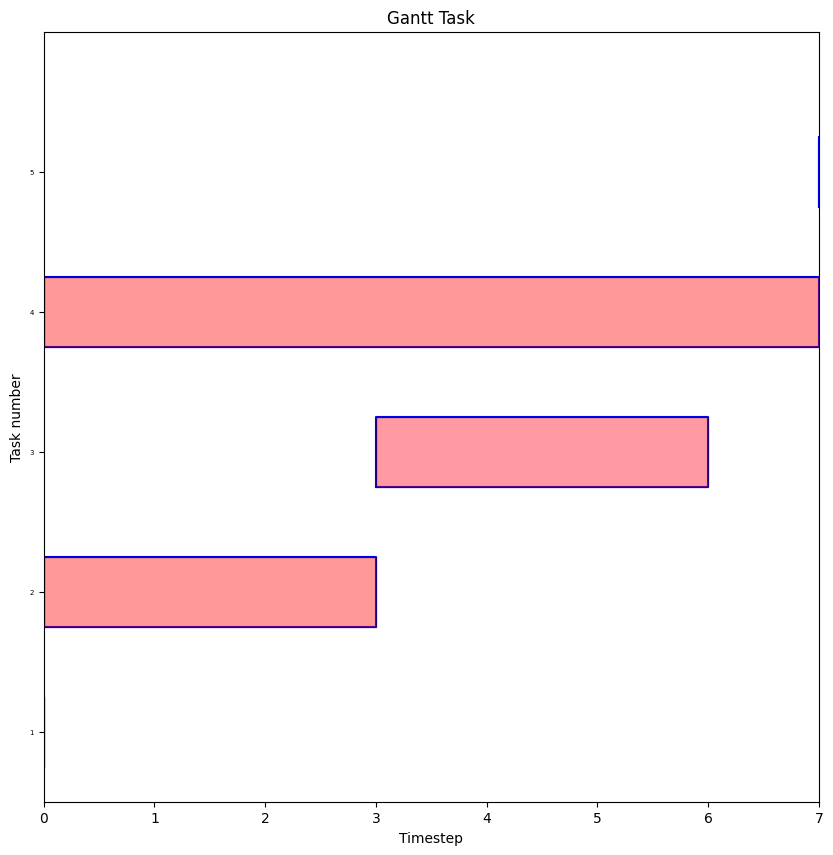

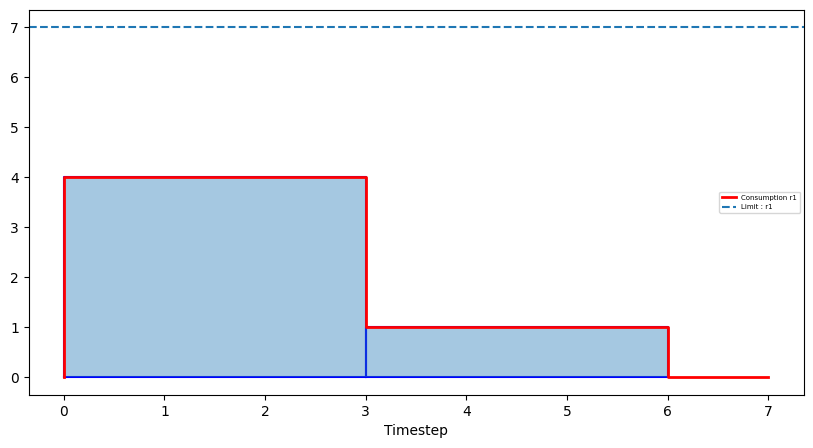

In [7]:
# Ploting solution
states = episode[0]
do_sol = from_last_state_to_solution(states[-1], domain)
# Each line of the plot is a task
fig_gantt = plot_task_gantt(do_sol.problem, do_sol)
# Plot resource consumption plot
fig_resource = plot_ressource_view(do_sol.problem, do_sol)

## Solving with combinatorial optimization 

[Discrete Optimization](https://github.com/airbus/discrete-optimization) library is the scheduling engine to solve scikit-decide scheduling domains. It implements an extensive API similar to scikit-decide for combinatorial optimization problems.

It implements a wide range of domain (optimisation problems):
- knapsack, coloring, tsp, vrp, maximum independent set, facility location, rcpsp and variants.

All problems have a complete set of solving solvers available : 
- Mathematical programming methods (Milp with open source solver and Gurobi, CP with Ortools, minizinc models..)
- Local search and genetic algorithms
- Custom heuristics (queue scheduling etc)

In [10]:
if len(get_data_available()) == 0:
    fetch_data_from_psplib()
file = [f for f in get_data_available() if "j1201_1.sm" in f][0]
rcpsp_domain = load_domain(file)
rcpsp_domain.set_inplace_environment(False)

2024-05-28 11:52:37,318 | skdecide.utils | INFO | The goal was reached in episode 1.


{'makespan': 143.0, 'mean_resource_reserve': 0.0, 'constraint_penalty': 0.0}


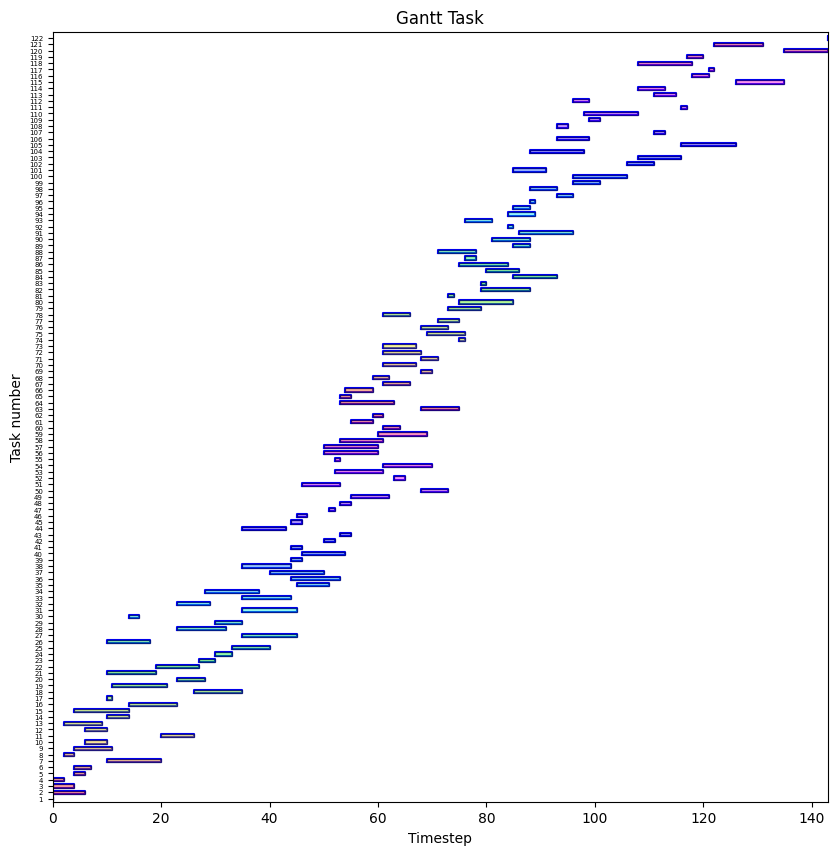

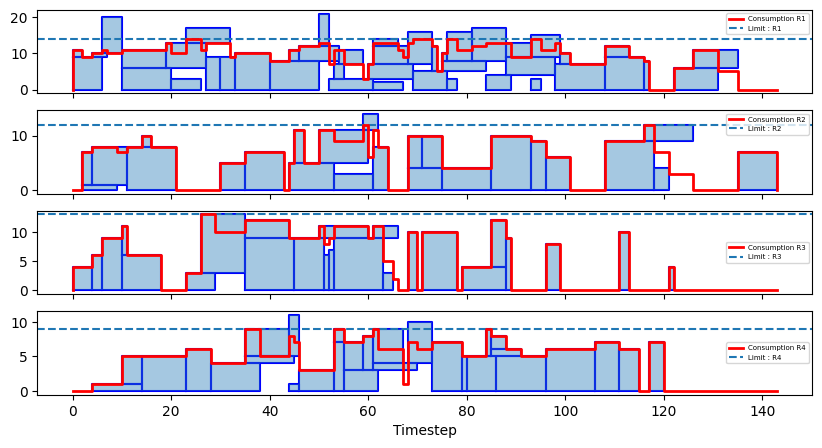

In [11]:
# Setting a priority queue scheduling (based on Serial generation scheme and a priority queue) :
params = PolicyMethodParams(
    base_policy_method=BasePolicyMethod.SGS_INDEX_FREEDOM,
    delta_index_freedom=10,
    delta_time_freedom=0,
)
p = PolicyRCPSP(
    domain=rcpsp_domain,
    policy_method_params=params,
    permutation_task=rcpsp_domain.task_ids,
    modes_dictionnary={i + 1: 1 for i in range(len(rcpsp_domain.task_ids))},
)
episode = rollout(
    domain=rcpsp_domain, solver=p, verbose=False, return_episodes=True, num_episodes=1
)[0]
states = episode[0]
do_sol = from_last_state_to_solution(states[-1], rcpsp_domain)
print(do_sol.problem.evaluate(do_sol))
fig_gantt = plot_task_gantt(do_sol.problem, do_sol)
fig_resource = plot_ressource_view(do_sol.problem, do_sol)

In [12]:
# Solving with Constraint programming solver (Chuffed solver by default)
p = ParametersCP.default_cpsat()
p.time_limit = 5
solver = DOSolver(
    domain_factory=lambda: rcpsp_domain,
    method=SolvingMethod.CP,
    policy_method_params=PolicyMethodParams(
        base_policy_method=BasePolicyMethod.FOLLOW_GANTT
    ),
    dict_params={"parameters_cp": p},
)
solver.solve()

In [13]:
episode = rollout(
    domain=rcpsp_domain,
    solver=solver,
    verbose=False,
    return_episodes=True,
    num_episodes=1,
)[0]

2024-05-28 11:53:24,198 | skdecide.utils | INFO | The goal was reached in episode 1.


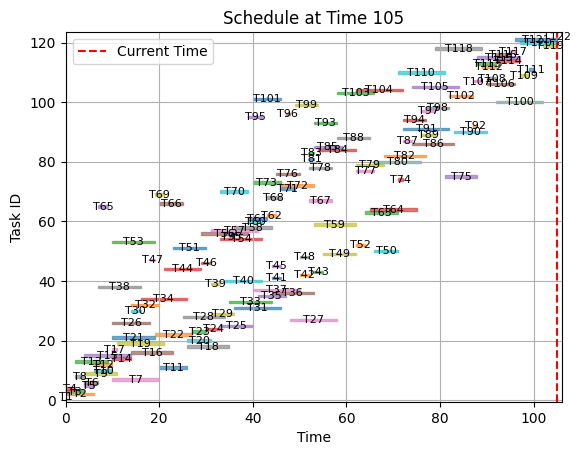

In [14]:
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import Rectangle


def plot_schedule(ax, state):
    ax.clear()
    ax.set_title(f"Schedule at Time {state.t}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Task ID")
    # Define colors for tasks
    colors = plt.cm.tab10.colors
    # Collect task IDs that are scheduled
    scheduled_tasks = [
        task_id
        for task_id, task in state.tasks_full_details.items()
        if task.start is not None
    ]
    # Plot each task as a rectangle
    for idx, (task_id, task) in enumerate(state.tasks_full_details.items()):
        if task.start is not None and task.end is not None:
            rect = Rectangle(
                (task.start, task_id - 0.4),
                task.end - task.start,
                0.8,
                color=colors[idx % 10],
                alpha=0.6,
            )
            ax.add_patch(rect)
            ax.text(
                (task.start + task.end) / 2,
                task_id,
                f"T{task_id}",
                ha="center",
                va="center",
                color="black",
                fontsize=8,
            )
        if task.start is not None and task.end is None:
            rect = Rectangle(
                (task.start, task_id - 0.4),
                state.t - task.start,
                0.8,
                color=colors[idx % 10],
                alpha=0.6,
                linestyle="dashed",
            )
            ax.add_patch(rect)
            ax.text(
                (task.start + state.t) / 2,
                task_id,
                f"T{task_id}",
                ha="center",
                va="center",
                color="black",
                fontsize=8,
            )

    # Plot the current time line
    ax.axvline(state.t, color="r", linestyle="--", label="Current Time")
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0, max(state.t + 1, 10))
    if scheduled_tasks:
        ax.set_ylim(min(scheduled_tasks) - 1.5, max(scheduled_tasks) + 1.5)


# Function to animate the plot
def animate(i):
    plot_schedule(ax, episode[0][i])


# Create the animation
fig, ax = plt.subplots()
ani = FuncAnimation(fig, animate, frames=len(episode[0]), repeat=False)
gif_path = "schedule_animation.gif"
ani.save(gif_path, writer=PillowWriter(fps=3))
plt.show()

![Schedule Animation](images/schedule_animation.gif)

## Hyperparameter optimisation
Discrete Optimization solvers come with hyperparameters API opening the possibility to do hyperparam optimisation using the optuna library which is easily integrated to it.
Hyperparams of solver can be for examples : 
- temperature, cooling factor for metaheuristics such as Simulated annealing
- population size, mutation and crossover operators for genetic algorithms
- solver backend or model variants for CP approaches etc.

In [15]:
from discrete_optimization.generic_rcpsp_tools.large_neighborhood_search_scheduling import \
    LargeNeighborhoodSearchScheduling
from discrete_optimization.generic_rcpsp_tools.ls_solver import LS_RCPSP_Solver
from discrete_optimization.rcpsp.solver.cp_solvers import CP_RCPSP_MZN
from discrete_optimization.rcpsp.solver.rcpsp_ga_solver import GA_RCPSP_Solver

print("CP Solver hyperparams", CP_RCPSP_MZN.hyperparameters, "\n")
print("LNS hyperparams : ", LargeNeighborhoodSearchScheduling.hyperparameters, "\n")
print("Local search hyperparams : ", LS_RCPSP_Solver.hyperparameters, "\n")
print("Genetic algorithms hyperparams : ", GA_RCPSP_Solver.hyperparameters, "\n")

CP Solver hyperparams [] 

LNS hyperparams :  [] 

Local search hyperparams :  [] 

Genetic algorithms hyperparams :  [] 



In [16]:
from rcpsp_domains.multi_solve_optuna import run_optuna_multisolve

In [ ]:
run_optuna_multisolve(rcpsp_domain)

In [17]:
import subprocess
import threading

from dash import Dash, html


# Function to run the Optuna dashboard
def run_dashboard():
    subprocess.run(["optuna-dashboard", "optuna-journal.log"])


# Start the dashboard server in a separate thread
thread = threading.Thread(target=run_dashboard)
thread.start()

In [21]:
# Create a Dash application
app = Dash(__name__)
# Define the layout of the app with an iframe to the Optuna dashboard
app.layout = html.Div(
    [
        html.Iframe(
            src="http://localhost:8080", style={"width": "100%", "height": "800px"}
        )
    ]
)
# Function to run the Dash app in the notebook
def run_app():
    app.run_server(mode="notebook")


# Run the app in the notebook
run_app()

127.0.0.1 - - [28/May/2024 11:56:03] "GET / HTTP/1.1" 302 0
127.0.0.1 - - [28/May/2024 11:56:03] "GET /dashboard HTTP/1.1" 304 0
127.0.0.1 - - [28/May/2024 11:56:03] "GET /static/bundle.js HTTP/1.1" 200 2986981
127.0.0.1 - - [28/May/2024 11:56:03] "GET /api/studies HTTP/1.1" 200 4893
127.0.0.1 - - [28/May/2024 11:56:05] "GET /api/meta HTTP/1.1" 200 63
/Users/poveda_g/Library/Caches/pypoetry/virtualenvs/scikit-decide-A3wwHfZU-py3.10/lib/python3.10/site-packages/optuna_dashboard/_importance.py:75: ExperimentalWarning: PedAnovaImportanceEvaluator is experimental (supported from v3.6.0). The interface can change in the future.
  return get_param_importances(study, target=target, evaluator=PedAnovaImportanceEvaluator())
127.0.0.1 - - [28/May/2024 11:56:05] "GET /api/studies/35?after=0 HTTP/1.1" 200 238987
/Users/poveda_g/Library/Caches/pypoetry/virtualenvs/scikit-decide-A3wwHfZU-py3.10/lib/python3.10/site-packages/optuna/importance/_ped_anova/evaluator.py:150: UserWarning: PedAnovaImportanc

## Reinforcement learning
As additional (ongoing) works, we introduce new domains for specific scheduling problems, more adapted for reinforcement learning solvers to be run on.


In [22]:
from discrete_optimization.rcpsp.rcpsp_parser import (get_data_available,
                                                      parse_file)
from rcpsp_domains.rcpsp_sk_domain import (ParamsDomainEncoding, RCPSPModel,
                                           RCPSPSGSDomain)

file = [f for f in get_data_available() if "j301_1.sm" in f][0]
model: RCPSPModel = parse_file(file)
domain_sk = RCPSPSGSDomain(
    model,
    params_domain_encoding=ParamsDomainEncoding(
        return_times_in_state=True,
        return_scheduled_in_state=True,
        use_cpm_for_cost=False,
        terminate_when_already_schedule=False,
        dummy_cost_when_already_schedule=30,
        use_additive_makespan_for_cost=True,
        nb_min_task_inserted=8,
        nb_max_task_inserted=25,
        filter_tasks=True,
        only_available_tasks=False,
    ),
)

127.0.0.1 - - [28/May/2024 12:00:18] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:00:23] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:00:28] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:00:33] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:00:39] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:00:44] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:00:49] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:00:55] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:01:01] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:01:07] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:01:13] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:01:19] "GET /

In [23]:
# Some utils functions
def run_rollout(domain, solver=None, nb_rollout=100):
    makespans = []
    for i in range(1000):
        episodes = rollout(
            domain=domain,
            solver=solver,
            verbose=False,
            num_episodes=1,
            return_episodes=True,
        )
        if domain.state[-1, 0]:
            solution_rcpsp = RCPSPSolution(
                problem=model,
                rcpsp_schedule={
                    t: {
                        "start_time": domain.state[domain.task_to_index[t], 1],
                        "end_time": domain.state[domain.task_to_index[t], 1]
                        + domain.dur[domain.task_to_index[t]],
                    }
                    for t in model.tasks_list
                },
            )
            # print(model.evaluate(solution_rcpsp), model.satisfy(solution_rcpsp))
            makespans.append(domain_sk.state[-1, 1])
    return makespans


def compute_statistics(arr):
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a numpy array")
    statistics = {
        "mean": np.mean(arr),
        "median": np.median(arr),
        "min": np.min(arr),
        "max": np.max(arr),
        "25th percentile": np.percentile(arr, 25),
        "50th percentile": np.percentile(arr, 50),
        "75th percentile": np.percentile(arr, 75),
    }
    return statistics

127.0.0.1 - - [28/May/2024 12:01:43] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869


### Random rollouts
Let's run random rollout on this domain.

In [24]:
makespans_random = run_rollout(domain_sk, solver=None, nb_rollout=100)

127.0.0.1 - - [28/May/2024 12:01:49] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:01:55] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:02:01] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869


{'mean': 53.49, 'median': 53.0, 'min': 47, 'max': 64, '25th percentile': 51.0, '50th percentile': 53.0, '75th percentile': 56.0}


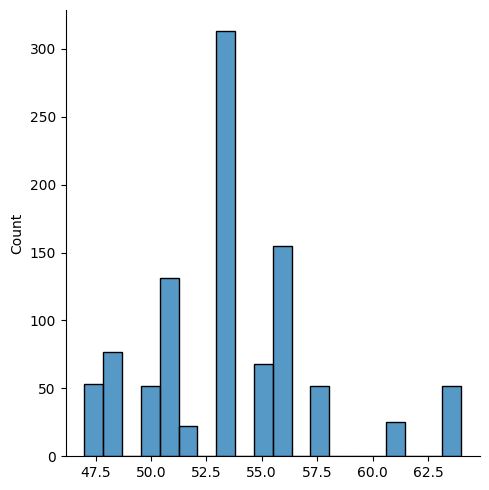

127.0.0.1 - - [28/May/2024 12:02:07] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:02:13] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:02:19] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:02:25] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:02:31] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869


In [25]:
stats = compute_statistics(np.array(makespans_random))
print(stats)
sns.displot(makespans_random, bins=20)

### Few words on RL solvers
Certainly! Here are brief descriptions of PPO, A2C, and DQN algorithms:

#### Proximal Policy Optimization (PPO)
- **Type**: Policy-based method.
- **Mechanism**: Utilizes a clipped surrogate objective to update policies, balancing exploration and exploitation.
- **Advantages**: 
  - More stable and reliable training compared to earlier policy gradient methods.
  - Suitable for both discrete and continuous action spaces.
- **Usage**: Popular in many reinforcement learning applications, including robotics and games.

#### Advantage Actor-Critic (A2C)
- **Type**: Actor-Critic method.
- **Mechanism**: Combines value-based and policy-based methods, using an actor to decide actions and a critic to evaluate them.
- **Advantages**: 
  - Efficient and relatively easy to implement.
  - Good balance between bias and variance, leading to more stable learning.
- **Usage**: Effective for various control problems and environments with continuous action spaces.

#### Deep Q-Network (DQN)
- **Type**: Value-based method.
- **Mechanism**: Uses deep neural networks to approximate the Q-value function, enabling handling of high-dimensional state spaces.
- **Advantages**: 
  - Demonstrated success in complex environments like Atari games.
  - Employs techniques like experience replay and target networks for stable training.
- **Usage**: Ideal for problems with discrete action spaces and where the state-action space can be effectively represented with deep learning.

### A2C with stable baselines

In [26]:
import nest_asyncio
from discrete_optimization.rcpsp.solver.cp_solvers import (CP_RCPSP_MZN,
                                                           ParametersCP)

nest_asyncio.apply()
solver = CP_RCPSP_MZN(model)
p = ParametersCP.default_cpsat()
p.time_limit = 2
res = solver.solve(parameters_cp=p)
sol, fit = res.get_best_solution_fit()
print(fit)

-43.0


127.0.0.1 - - [28/May/2024 12:02:37] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:02:43] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:02:49] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:02:55] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869


In [27]:
from rcpsp_domains.rcpsp_sk_domain import RCPSPSGSDomain, records

records.clear()
domain_sk = RCPSPSGSDomain(
    model,
    params_domain_encoding=ParamsDomainEncoding(
        return_times_in_state=True,
        return_scheduled_in_state=True,
        use_cpm_for_cost=True,
        terminate_when_already_schedule=False,
        dummy_cost_when_already_schedule=1,
        use_additive_makespan_for_cost=False,
        nb_min_task_inserted=1,
        nb_max_task_inserted=None,
        filter_tasks=False,
        only_available_tasks=False,
    ),
)
from stable_baselines3 import A2C, DQN, PPO

solver_args = {
    "baselines_policy": "MlpPolicy",
    "learn_config": {"total_timesteps": 100000},
    "verbose": 0,
    "n_steps": 300,
    # "batch_size": 100
}
solver_args.update(
    {
        "policy_kwargs": dict(
            net_arch=[dict(pi=[256, 256, 128, 128], vf=[256, 256, 128, 128])]
        )
    }
)
solver_args["algo_class"] = A2C
solver = StableBaseline(domain_factory=lambda: domain_sk, **solver_args)
# Start solving
solver.solve()
makespans_a2c = run_rollout(domain_sk, solver=solver, nb_rollout=100)

/Users/poveda_g/Library/Caches/pypoetry/virtualenvs/scikit-decide-A3wwHfZU-py3.10/lib/python3.10/site-packages/gymnasium/wrappers/compatibility.py:67: DeprecationWarning:

WARN: The `gymnasium.make(..., apply_api_compatibility=...)` parameter is deprecated and will be removed in v0.29. Instead use `gym.make('GymV21Environment-v0', env_name=...)` or `from shimmy import GymV21CompatibilityV0`

/Users/poveda_g/Library/Caches/pypoetry/virtualenvs/scikit-decide-A3wwHfZU-py3.10/lib/python3.10/site-packages/stable_baselines3/common/policies.py:486: UserWarning:

As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])

127.0.0.1 - - [28/May/2024 12:03:01] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:03:07] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:03:13] "GET /api/studies/35?after

{'mean': 43.002, 'median': 43.0, 'min': 43, 'max': 45, '25th percentile': 43.0, '50th percentile': 43.0, '75th percentile': 43.0}


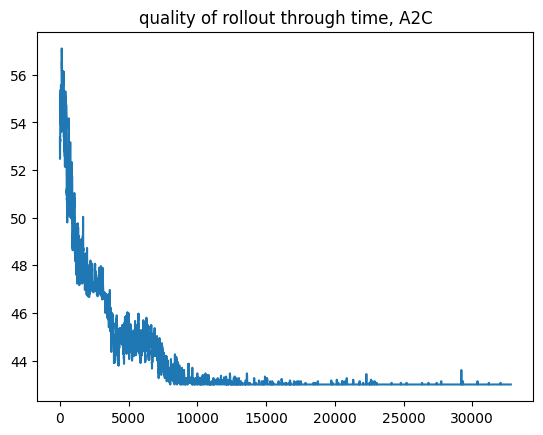

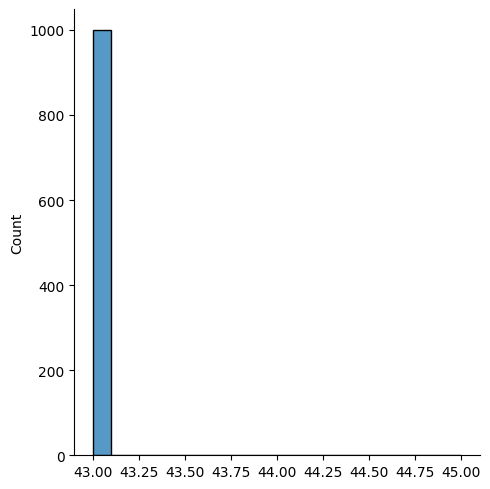

127.0.0.1 - - [28/May/2024 12:04:19] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:04:25] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:04:31] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:04:37] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:04:43] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:04:49] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:04:55] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:05:01] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:05:07] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:05:13] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:05:19] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:05:25] "GET /

In [28]:
fig, ax = plt.subplots(1)
records_a2c = np.array(records)
ax.plot(np.convolve(records_a2c, np.ones(30) / 30, mode="valid"))
ax.set_title("quality of rollout through time, A2C")
sns.displot(makespans_a2c, bins=20)
print(compute_statistics(np.array(makespans_a2c)))
plt.show()

### DQN with stable baselines

In [29]:
from rcpsp_domains.rcpsp_sk_domain import RCPSPSGSDomain, records

records.clear()
domain_sk = RCPSPSGSDomain(
    model,
    params_domain_encoding=ParamsDomainEncoding(
        return_times_in_state=True,
        return_scheduled_in_state=True,
        use_cpm_for_cost=True,
        terminate_when_already_schedule=False,
        dummy_cost_when_already_schedule=1,
        use_additive_makespan_for_cost=False,
        nb_min_task_inserted=1,
        nb_max_task_inserted=None,
        filter_tasks=False,
        only_available_tasks=False,
    ),
)
from stable_baselines3 import A2C, DQN, PPO

solver_args = {
    "baselines_policy": "MlpPolicy",
    "learn_config": {"total_timesteps": 100000},
    "verbose": 0,
}
solver_args["algo_class"] = DQN
solver = StableBaseline(domain_factory=lambda: domain_sk, **solver_args)
# Start solving
solver.solve()
makespans_dqn = run_rollout(domain_sk, solver=solver, nb_rollout=100)

/Users/poveda_g/Library/Caches/pypoetry/virtualenvs/scikit-decide-A3wwHfZU-py3.10/lib/python3.10/site-packages/gymnasium/wrappers/compatibility.py:67: DeprecationWarning:

WARN: The `gymnasium.make(..., apply_api_compatibility=...)` parameter is deprecated and will be removed in v0.29. Instead use `gym.make('GymV21Environment-v0', env_name=...)` or `from shimmy import GymV21CompatibilityV0`

127.0.0.1 - - [28/May/2024 12:11:07] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:11:13] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:11:19] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:11:25] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:11:31] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:11:37] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:11:43] "GET /api/studies/35?after=100 HTTP/1.1" 200 5

{'mean': 55.201, 'median': 58.0, 'min': 43, 'max': 64, '25th percentile': 51.0, '50th percentile': 58.0, '75th percentile': 58.0}


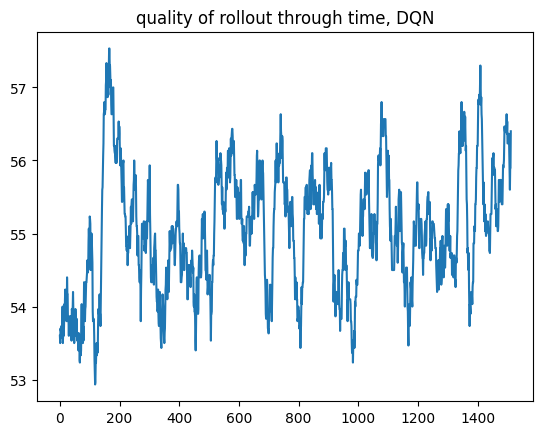

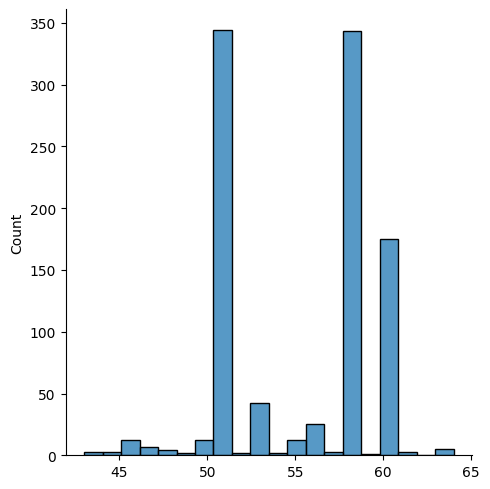

127.0.0.1 - - [28/May/2024 12:12:49] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:12:55] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:13:01] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:13:07] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869


In [30]:
fig, ax = plt.subplots(1)
records_dqn = np.array(records)
ax.plot(np.convolve(records_dqn, np.ones(30) / 30, mode="valid"))
ax.set_title("quality of rollout through time, DQN")
sns.displot(makespans_dqn, bins=20)
print(compute_statistics(np.array(makespans_dqn)))
plt.show()

### PPO with stable baselines

In [ ]:
from rcpsp_domains.rcpsp_sk_domain import RCPSPSGSDomain, records
from skdecide.hub.solver.ray_rllib import RayRLlib
from skdecide.hub.solver.stable_baselines import StableBaseline

records.clear()
domain_sk = RCPSPSGSDomain(
    model,
    params_domain_encoding=ParamsDomainEncoding(
        return_times_in_state=True,
        return_scheduled_in_state=True,
        use_cpm_for_cost=True,
        terminate_when_already_schedule=False,
        dummy_cost_when_already_schedule=1,
        use_additive_makespan_for_cost=False,
        nb_min_task_inserted=1,
        nb_max_task_inserted=None,
        filter_tasks=False,
        only_available_tasks=False,
    ),
)
from stable_baselines3 import A2C, DQN, PPO

solver_args = {
    "baselines_policy": "MlpPolicy",
    "learn_config": {"total_timesteps": 100000},
    "verbose": 0,
    "learning_rate": 0.0001,
    "n_steps": 300,
    # "batch_size": 100
}
solver_args.update(
    {
        "policy_kwargs": dict(
            net_arch=[dict(pi=[256, 256, 128, 128], vf=[256, 256, 128, 128])]
        )
    }
)
solver_args["algo_class"] = PPO
solver = StableBaseline(domain_factory=lambda: domain_sk, **solver_args)
# Start solving
solver.solve()
print("Solve finished : ")
makespans_ppo = run_rollout(domain_sk, solver=solver, nb_rollout=100)

In [ ]:
fig, ax = plt.subplots(1)
records_ppo = np.array(records)
ax.plot(np.convolve(records_ppo, np.ones(30) / 30, mode="valid"))
ax.set_title("quality of rollout through time, PPO")
print(compute_statistics(np.array(makespans_ppo)))
plt.show()

### DQN With RLLIB

In [31]:
from ray.rllib.algorithms.dqn import DQN
from ray.rllib.algorithms.ppo import PPO
from rcpsp_domains.rcpsp_sk_domain import RCPSPSGSDomain, records

records.clear()
from skdecide.hub.solver.ray_rllib import RayRLlib

ac = DQN.get_default_config()
ac.lr = 1e-4
# ac.framework("torch")
# ac.num_env_runners = 8
# ac.num_workers = 1
# ac.num_env_runners = 1
# ac.sgd_minibatch_size = 16
# ac.rollout_fragment_length = "auto"
domain_sk = RCPSPSGSDomain(
    model,
    params_domain_encoding=ParamsDomainEncoding(
        return_times_in_state=True,
        return_scheduled_in_state=True,
        use_cpm_for_cost=False,
        terminate_when_already_schedule=False,
        dummy_cost_when_already_schedule=30,
        use_additive_makespan_for_cost=True,
        nb_min_task_inserted=1,
        nb_max_task_inserted=25,
        filter_tasks=True,
        only_available_tasks=False,
    ),
)
solver = RayRLlib(
    domain_factory=lambda: domain_sk.shallow_copy(),
    algo_class=DQN,
    config=ac,
    train_iterations=20,
)
assert RayRLlib.check_domain(domain_sk)
solver.solve()
makespan_rllib = run_rollout(domain_sk, solver=solver, nb_rollout=100)
records_rllib = np.array(records)

2024-05-28 12:13:12,637	INFO worker.py:1749 -- Started a local Ray instance.
/Users/poveda_g/Library/Caches/pypoetry/virtualenvs/scikit-decide-A3wwHfZU-py3.10/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:525: RayDeprecationWarning:

This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.

/Users/poveda_g/Library/Caches/pypoetry/virtualenvs/scikit-decide-A3wwHfZU-py3.10/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning:

This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.

/Users/poveda_g/Library/Caches/pypoetry/virtualenvs/scikit-decide-A3wwHf

### Compare different solvers ? 

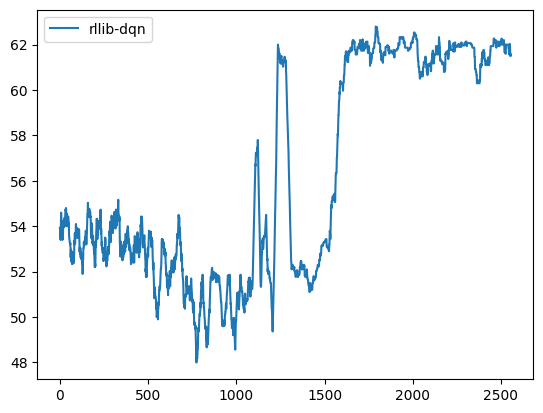

127.0.0.1 - - [28/May/2024 12:17:19] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:17:25] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:17:31] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:17:37] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:17:43] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:17:49] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:17:55] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:18:01] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:18:07] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:18:13] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:18:19] "GET /api/studies/35?after=100 HTTP/1.1" 200 5869
127.0.0.1 - - [28/May/2024 12:18:25] "GET /

In [33]:
fig, ax = plt.subplots(1)
#ax.plot(np.convolve(records_ppo, np.ones(30) / 30, mode="valid"), label="ppo")
#ax.plot(np.convolve(records_a2c, np.ones(30) / 30, mode="valid"), label="a2c")
#ax.plot(np.convolve(records_dqn, np.ones(30) / 30, mode="valid"), label="dqn")
ax.plot(np.convolve(records_rllib, np.ones(30) / 30, mode="valid"), label="rllib-dqn")
ax.legend()

### RL on stochastic domain
RL is particularly suited for stochastic domains.

In [ ]:
from discrete_optimization.rcpsp.rcpsp_model import RCPSPSolution
from rcpsp_domains.stochastic_rcpsp_sk_domain import (StochasticRCPSPSGSDomain,
                                                      records)
from skdecide.hub.solver.stable_baselines import StableBaseline
from skdecide.utils import rollout

records.clear()
domain_sk = StochasticRCPSPSGSDomain(
    model,
    params_domain_encoding=ParamsDomainEncoding(
        return_times_in_state=True,
        return_scheduled_in_state=True,
        use_cpm_for_cost=True,
        terminate_when_already_schedule=False,
        dummy_cost_when_already_schedule=1,
        use_additive_makespan_for_cost=False,
        nb_min_task_inserted=1,
        nb_max_task_inserted=None,
        filter_tasks=False,
        only_available_tasks=False,
    ),
)
from stable_baselines3 import A2C, DQN, PPO

solver_args = {
    "baselines_policy": "MlpPolicy",
    "learn_config": {"total_timesteps": 100000},
    "verbose": 0,
    # "learning_rate": 0.05,
    "n_steps": 300,
    # "batch_size": 100
}
solver_args.update(
    {
        "policy_kwargs": dict(
            net_arch=[dict(pi=[256, 256, 128, 128], vf=[256, 256, 128, 128])]
        )
    }
)
solver_args["algo_class"] = A2C
solver = StableBaseline(domain_factory=lambda: domain_sk, **solver_args)
# Start solving
solver.solve()
makespan_stochastic = []
for k in range(100):
    episodes = rollout(
        domain=domain_sk,
        solver=solver,
        num_episodes=1,
        verbose=False,
        return_episodes=True,
    )
    if domain_sk.state[-1, 0]:
        solution_rcpsp = RCPSPSolution(
            problem=model,
            rcpsp_schedule={
                t: {
                    "start_time": domain_sk.state[domain_sk.task_to_index[t], 1],
                    "end_time": domain_sk.state[domain_sk.task_to_index[t], 1]
                    + domain_sk.dur[domain_sk.task_to_index[t]],
                }
                for t in model.tasks_list
            },
        )
        makespan_stochastic.append(domain_sk.state[-1, 1])

In [ ]:
fig, ax = plt.subplots(1)
records_stochastic = np.array(records)
ax.plot(np.convolve(records_stochastic, np.ones(30) / 30, mode="valid"))
print(compute_statistics(np.array(makespan_stochastic)))
plt.show()

### Other approaches with RL
One natural way of using RL is to combine it with a local search domain. Actions consists in moving an existing schedule by local moves, and the goal is to apply a sequence of local move that minimizes the fitness.

In [ ]:
def run_rollout_ls(domain, solver=None, nb_rollout=100):
    makespans = []
    for i in range(1000):
        episodes = rollout(
            domain=domain,
            solver=solver,
            verbose=False,
            num_episodes=1,
            return_episodes=True,
        )
        solution_rcpsp = RCPSPSolution(
            problem=model,
            rcpsp_schedule={
                t: {
                    "start_time": domain.state[domain.task_to_index[t]],
                    "end_time": domain.state[domain.task_to_index[t]]
                    + domain.dur[domain.task_to_index[t]],
                }
                for t in model.tasks_list
            },
        )
        makespans.append(domain_sk.state[-1])
    return makespans

#### Local search
Moves are basic 2-Opt on the permutation (priority queue) of tasks.

In [ ]:
from rcpsp_domains.rcpsp_sk_domain_local_search import (ParamsDomainEncodingLS,
                                                        RCPSP_LS_Domain,
                                                        records)

records.clear()
params = ParamsDomainEncodingLS(
    use_multidiscrete=True, use_boxspace=False, depth_terminal=10
)
domain_sk = RCPSP_LS_Domain(model, params_domain_encoding=params)
from stable_baselines3 import A2C, DQN, PPO

solver_args = {
    "baselines_policy": "MlpPolicy",
    "learn_config": {"total_timesteps": 50000},
    "verbose": 0,
}
solver_args.update(
    {
        "policy_kwargs": dict(
            net_arch=[dict(pi=[128, 128, 128, 128], vf=[128, 128, 128, 128])]
        )
    }
)
solver_args["algo_class"] = A2C
solver = StableBaseline(domain_factory=lambda: domain_sk, **solver_args)
solver.solve()

In [ ]:
fig, ax = plt.subplots(1)
records_ = np.array(records)
ax.plot(np.convolve(records_, np.ones(30) / 30, mode="valid"))
plt.show()

#### Permutation optimisation in 1 step
We can also use RL to optimize directly the full permutation

In [ ]:
import os

os.environ["RAY_DEDUP_LOGS"] = "0"
from rcpsp_domains.rcpsp_sk_domain_local_search import (
    ParamsDomainEncodingLSOneStep, RCPSP_LS_Domain, RCPSP_LS_Domain_OneStep,
    records)

records.clear()
domain_sk = RCPSP_LS_Domain_OneStep(model)
from ray.rllib.algorithms.ppo import PPO

config = PPO.get_default_config()
config.num_rollout_workers = 5
config.num_env_runners = 5
config.log_level = "INFO"
solver = RayRLlib(
    domain_factory=lambda: domain_sk.shallow_copy(),
    config=config,
    algo_class=PPO,
    train_iterations=20,
)
solver.solve()
makespans_rllib_one_step = run_rollout_ls(domain_sk, solver, 100)
records_rllib = np.array(records)
print(compute_statistics(np.array(makespans_rllib_one_step)))

In [ ]:
from rcpsp_domains.rcpsp_sk_domain_local_search import (
    ParamsDomainEncodingLSOneStep, RCPSP_LS_Domain, RCPSP_LS_Domain_OneStep,
    records)

records.clear()
params = ParamsDomainEncodingLSOneStep(action_as_float=False, action_as_int=True)
domain_sk = RCPSP_LS_Domain_OneStep(model, params_domain_encoding=params)
from stable_baselines3 import A2C, DQN, PPO

solver_args = {
    "baselines_policy": "MlpPolicy",
    "learn_config": {"total_timesteps": 50000},
    "verbose": 0,
}
solver_args.update(
    {
        "policy_kwargs": dict(
            net_arch=[dict(pi=[128, 128, 128, 128], vf=[128, 128, 128, 128])]
        )
    }
)
solver_args["algo_class"] = A2C
solver = StableBaseline(domain_factory=lambda: domain_sk, **solver_args)
solver.solve()
makespans_sb_one_step = run_rollout_ls(domain_sk, solver, 100)
print(compute_statistics(np.array(makespans_sb_one_step)))

In [ ]:
fig, ax = plt.subplots(1)
records_sb = np.array(records)
ax.plot(np.convolve(records_sb, np.ones(30) / 30, mode="valid"), label="sb")
ax.plot(np.convolve(records_rllib, np.ones(30) / 30, mode="valid"), label="rllib")
ax.legend()